In [2]:
import numpy as np

class ActivationFunction:


    @staticmethod
    def linear(x):
        return x

    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def tanh(x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Bonus: Swish, softplus, and ELU
    @staticmethod
    def swish(x):
        return x * ActivationFunction.sigmoid(x)

    @staticmethod
    def softplus(x):
        return np.log(1 + np.exp(x))

    @staticmethod
    def elu(x, alpha=1.0):
        return np.where(x > 0, x, alpha * (np.exp(x) - 1))

class LossFunction:


    @staticmethod
    def mse(yi, y_hat):
        return np.mean((yi - y_hat) ** 2)

    @staticmethod
    def binCrossEntropy(yi, y_hat):
        return -np.mean(yi * np.log(y_hat) + (1 - yi) * np.log(1 - y_hat))

    @staticmethod
    def catCrossEntropy(yi, y_hat):
        eps = 1e-15
        y_hat = np.clip(y_hat, eps, 1 - eps)

        n = yi.shape[0]

        loss = -np.sum(yi * np.log(y_hat)) / n

        return loss

In [3]:
class DenseLayer:
    def __init__(self, weight, bias, activation='linear'):
        self.weight = weight
        self.bias = bias
        self.activation = activation

    def forward(self, input):
        sigma = np.dot(input, self.weight) + self.bias
        return self._activate(sigma)

    def _activate(self, sigma):
        if self.activation == 'linear':
            return ActivationFunction.linear(sigma)
        elif self.activation == 'relu':
            return ActivationFunction.relu(sigma)
        elif self.activation == 'sigmoid':
            return ActivationFunction.sigmoid(sigma)
        elif self.activation == 'tanh':
            return ActivationFunction.tanh(sigma)
        elif self.activation == 'softmax':
            return ActivationFunction.softmax(sigma)
        elif self.activation == 'swish':
            return ActivationFunction.swish(sigma)
        elif self.activation == 'softplus':
            return ActivationFunction.softplus(sigma)
        elif self.activation == 'elu':
            return ActivationFunction.elu(sigma)
        else:
            raise ValueError("Unknown activation function")

In [4]:
import pandas as pd
import tensorflow_datasets as tfds
import os

class DataLoader:
    def __init__(self, dataset):
        self.dataset = dataset

    def load_data(self):
        if self.dataset == 'cifar10':
            ds, _ = tfds.load(self.dataset, with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]', 'test'], shuffle_files=True)
            train_data, val_data, test_data = ds

            x_train, y_train = self.ds_to_numpy(train_data)
            x_val, y_val = self.ds_to_numpy(val_data)
            x_test, y_test = self.ds_to_numpy(test_data)

            return x_train, x_val, x_test, y_train, y_val, y_test

        elif self.dataset == 'NusaX':
            BASE_DIR = os.path.dirname(os.path.abspath(__file__))
            base_path = os.path.join(BASE_DIR, 'NusaX')
            train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
            val_df = pd.read_csv(os.path.join(base_path, 'valid.csv'))
            test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

            x_train = train_df.drop(columns=['label']).values
            y_train = train_df['label'].values
            x_val = val_df.drop(columns=['label']).values
            y_val = val_df['label'].values
            x_test = test_df.drop(columns=['label']).values
            y_test = test_df['label'].values

            return np.array(x_train), np.array(x_val), np.array(x_test), np.array(y_train), np.array(y_val), np.array(y_test)

    def ds_to_numpy(self, ds):
        x, y = [], []

        for img, label in ds:
            x.append(np.array(img))
            y.append(np.array(label))

        x = np.array(x)
        y = np.array(y)

        return x, y

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class CNNModel:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def load_keras_model(self, keras_model):
        self.layers = []

        for i, keras_layer in enumerate(keras_model.layers):
            layer_name = keras_layer.name
            layer_type = type(keras_layer).__name__
            print(f"  Layer {i+1}: {layer_type} ({layer_name})")

            if isinstance(keras_layer, tf.keras.layers.Conv2D):
                config = keras_layer.get_config()
                conv_layer = Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding'],
                    activation=config['activation']
                )

                weights, bias = keras_layer.get_weights()
                conv_layer.set_weights(weights, bias)
                self.add_layer(conv_layer)
                print(f"    → Conv2D: {config['filters']} filters, {config['kernel_size']}x{config['kernel_size']} kernel")

            elif isinstance(keras_layer, tf.keras.layers.MaxPooling2D):
                config = keras_layer.get_config()
                pool_layer = Pooling(
                    pool_type='max',
                    pool_size=config['pool_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding']
                )
                self.add_layer(pool_layer)
                print(f"    → MaxPooling2D: {config['pool_size']}x{config['pool_size']} pool")

            elif isinstance(keras_layer, tf.keras.layers.AveragePooling2D):
                config = keras_layer.get_config()
                pool_layer = Pooling(
                    pool_type='avg',
                    pool_size=config['pool_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding']
                )
                self.add_layer(pool_layer)
                print(f"    → AveragePooling2D: {config['pool_size']}x{config['pool_size']} pool")

            elif isinstance(keras_layer, tf.keras.layers.Flatten):
                flatten_layer = Flatten()
                self.add_layer(flatten_layer)
                print(f"    → Flatten")

            elif isinstance(keras_layer, tf.keras.layers.Dense):
                config = keras_layer.get_config()
                weights, bias = keras_layer.get_weights()

                dense_layer = DenseLayer(
                    weight=weights,
                    bias=bias,
                    activation=config['activation']
                )
                self.add_layer(dense_layer)
                print(f"    → Dense: {config['units']} units, {config['activation']} activation")

        print(f"✓ Model loaded with {len(self.layers)} layers")

    def forward(self, X):
        output = X
        for i, layer in enumerate(self.layers):
            output = layer.forward(output)
        return output

    def predict(self, X, batch_size=32):
        n_samples = X.shape[0]
        predictions = []

        print(f"Predicting {n_samples} samples in batches of {batch_size}...")

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch = X[i:batch_end]

            if i % (batch_size * 10) == 0:
                print(f"  Processing batch {i//batch_size + 1}/{(n_samples-1)//batch_size + 1}")

            batch_pred = self.forward(batch)
            predictions.append(batch_pred)

        return np.vstack(predictions)

class Conv2D:
    def __init__(self, filters, kernel_size, strides, padding, activation='relu'):
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.kernel = None
        self.bias = None

    def set_weights(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def _pad_input(self, X):
        if self.padding == 'same':
            pad_h = (self.kernel_size - 1) // 2
            pad_w = (self.kernel_size - 1) // 2
            return np.pad(X, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        return X

    def _activation(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        return x

    def forward(self, X):
        X_padded = self._pad_input(X)
        batch_size, H, W, C_in = X_padded.shape
        K_h, K_w, C_in_w, C_out = self.weights.shape

        out_H = (H - K_h) // self.strides + 1
        out_W = (W - K_w) // self.strides + 1

        output = np.zeros((batch_size, out_H, out_W, C_out))

        for i in range(out_H):
            for j in range(out_W):
                h_start = i * self.strides
                h_end = h_start + K_h
                w_start = j * self.strides
                w_end = w_start + K_w

                patch = X_padded[:, h_start:h_end, w_start:w_end, :]

                for f in range(C_out):
                    output[:, i, j, f] = np.sum(patch * self.weights[:, :, :, f], axis=(1, 2, 3)) + self.bias[f]

        return self._activation(output)


class Pooling:
    def __init__(self, pool_type='max', pool_size=2, strides=2, padding='valid'):
        self.pool_type = pool_type
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def _pad_input(self, X):
        if self.padding == 'same':
            pad_h = (self.pool_size - 1) // 2
            pad_w = (self.pool_size - 1) // 2
            return np.pad(X, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        return X

    def forward(self, X):
        X_padded = self._pad_input(X)
        batch_size, H, W, C = X_padded.shape

        out_H = (H - self.pool_size) // self.strides + 1
        out_W = (W - self.pool_size) // self.strides + 1

        output = np.zeros((batch_size, out_H, out_W, C))

        for i in range(out_H):
            for j in range(out_W):
                h_start = i * self.strides
                h_end = h_start + self.pool_size
                w_start = j * self.strides
                w_end = w_start + self.pool_size

                patch = X_padded[:, h_start:h_end, w_start:w_end, :]

                if self.pool_type == 'max':
                    output[:, i, j, :] = np.max(patch, axis=(1, 2))
                else:
                    output[:, i, j, :] = np.mean(patch, axis=(1, 2))

        return output

class Flatten:
    def __init__(self):
        pass

    def forward(self, X):
        batch_size = X.shape[0]
        return X.reshape(batch_size, -1)


CNN HYPERPARAMETER EXPERIMENTS - CIFAR-10


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.ARCCAA_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.ARCCAA_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Dataset loaded:
  Training: (40000, 32, 32, 3) - 40000 samples
  Validation: (10000, 32, 32, 3) - 10000 samples
  Test: (10000, 32, 32, 3) - 10000 samples

################################################################################
EXPERIMENT 1: PENGARUH JUMLAH LAYER KONVOLUSI
################################################################################


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training: 1_conv_layer
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3853 - loss: 1.7125 - val_accuracy: 0.5376 - val_loss: 1.3307
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5612 - loss: 1.2423 - val_accuracy: 0.5697 - val_loss: 1.2407
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6079 - loss: 1.1184 - val_accuracy: 0.5881 - val_loss: 1.1856
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6335 - loss: 1.0382 - val_accuracy: 0.5985 - val_loss: 1.1715
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6577 - loss: 0.9735 - val_accuracy: 0.6023 - val_loss: 1.1688
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6808 - loss: 0.9170 - val_accuracy: 0.5987 - val_loss: 1.1966
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6984 - loss: 0.8682 - val_accuracy: 0.6006 - val_loss: 1.2143
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for 1_conv_layer:
  Test Accuracy: 0.5689
  Test F1-Score (macro): 0.5658

Training: 2_conv_layers
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3681 - loss: 1.7255 - val_accuracy: 0.5661 - val_loss: 1.2437
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5883 - loss: 1.1610 - val_accuracy: 0.6020 - val_loss: 1.1364
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6480 - loss: 1.0020 - val_accuracy: 0.6214 - val_loss: 1.0708
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6866 - loss: 0.9010 - val_accuracy: 0.6389 - val_loss: 1.0335
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7136 - loss: 0.8251 - val_accuracy: 0.6582 - val_loss: 0.9959
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7353 - loss: 0.7609 - val_accuracy: 0.6565 - val_loss: 1.0278
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7571 - loss: 0.7037 - val_accuracy: 0.6647 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for 2_conv_layers:
  Test Accuracy: 0.6470
  Test F1-Score (macro): 0.6457

Training: 3_conv_layers
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3554 - loss: 1.7456 - val_accuracy: 0.5760 - val_loss: 1.1964
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6080 - loss: 1.1044 - val_accuracy: 0.6320 - val_loss: 1.0587
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6799 - loss: 0.9112 - val_accuracy: 0.6676 - val_loss: 0.9631
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7214 - loss: 0.7904 - val_accuracy: 0.6869 - val_loss: 0.9141
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7560 - loss: 0.7060 - val_accuracy: 0.6898 - val_loss: 0.9233
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7795 - loss: 0.6360 - val_accuracy: 0.6905 - val_loss: 0.9734
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7986 - loss: 0.5749 - val_accuracy: 0.696

Results for 3_conv_layers:
  Test Accuracy: 0.6784
  Test F1-Score (macro): 0.6729


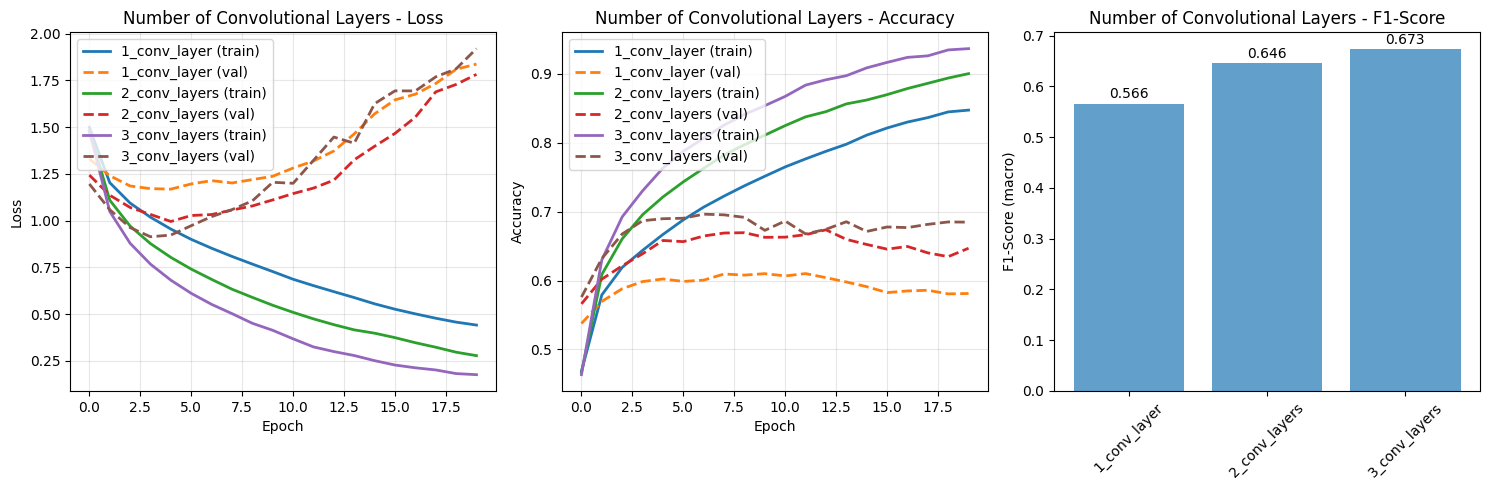


ANALISIS: PENGARUH JUMLAH LAYER KONVOLUSI
1 layer(s): F1-Score = 0.5658
2 layer(s): F1-Score = 0.6457
3 layer(s): F1-Score = 0.6729

KESIMPULAN:
- Performa terbaik: 3_conv_layers (F1-Score: 0.6729)
- Performa terburuk: 1_conv_layer (F1-Score: 0.5658)

################################################################################
EXPERIMENT 2: PENGARUH BANYAK FILTER PER LAYER
################################################################################

Training: filters_16_32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3507 - loss: 1.7813 - val_accuracy: 0.5620 - val_loss: 1.2489
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5643 - loss: 1.2255 - val_accuracy: 0.6117 - val_loss: 1.0959
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6268 - loss: 1.0735 - val_accuracy: 0.6341 - val_loss: 1.0347
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6557 - loss: 0.9861 - val_accuracy: 0.6484 - val_loss: 0.9947
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6784 - loss: 0.9222 - val_accuracy: 0.6613 - val_loss: 0.9663
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6962 - loss: 0.8731 - val_accuracy: 0.6684 - val_loss: 0.9535
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7109 - loss: 0.8304 - val_accuracy: 0.6746 - val_loss: 0.9464
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7225 - loss: 0.7930 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for filters_16_32:
  Test Accuracy: 0.6497
  Test F1-Score (macro): 0.6456

Training: filters_32_64
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3873 - loss: 1.6884 - val_accuracy: 0.5717 - val_loss: 1.1929
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6055 - loss: 1.1158 - val_accuracy: 0.6205 - val_loss: 1.0588
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6686 - loss: 0.9421 - val_accuracy: 0.6488 - val_loss: 0.9942
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7051 - loss: 0.8364 - val_accuracy: 0.6590 - val_loss: 0.9860
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7349 - loss: 0.7535 - val_accuracy: 0.6682 - val_loss: 0.9668
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7590 - loss: 0.6835 - val_accuracy: 0.6564 - val_loss: 1.0210
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7865 - loss: 0.6193 - val_accuracy: 0.6509

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for filters_32_64:
  Test Accuracy: 0.6393
  Test F1-Score (macro): 0.6357

Training: filters_64_128
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3738 - loss: 1.7031 - val_accuracy: 0.5908 - val_loss: 1.1571
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6107 - loss: 1.1034 - val_accuracy: 0.6523 - val_loss: 0.9982
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6736 - loss: 0.9312 - val_accuracy: 0.6661 - val_loss: 0.9671
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7144 - loss: 0.8233 - val_accuracy: 0.6640 - val_loss: 0.9920
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7416 - loss: 0.7437 - val_accuracy: 0.6703 - val_loss: 0.9993
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7700 - loss: 0.6661 - val_accuracy: 0.6606 - val_loss: 1.0743
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7915 - loss: 0.6008 - val_accuracy: 0.66

Results for filters_64_128:
  Test Accuracy: 0.6515
  Test F1-Score (macro): 0.6506


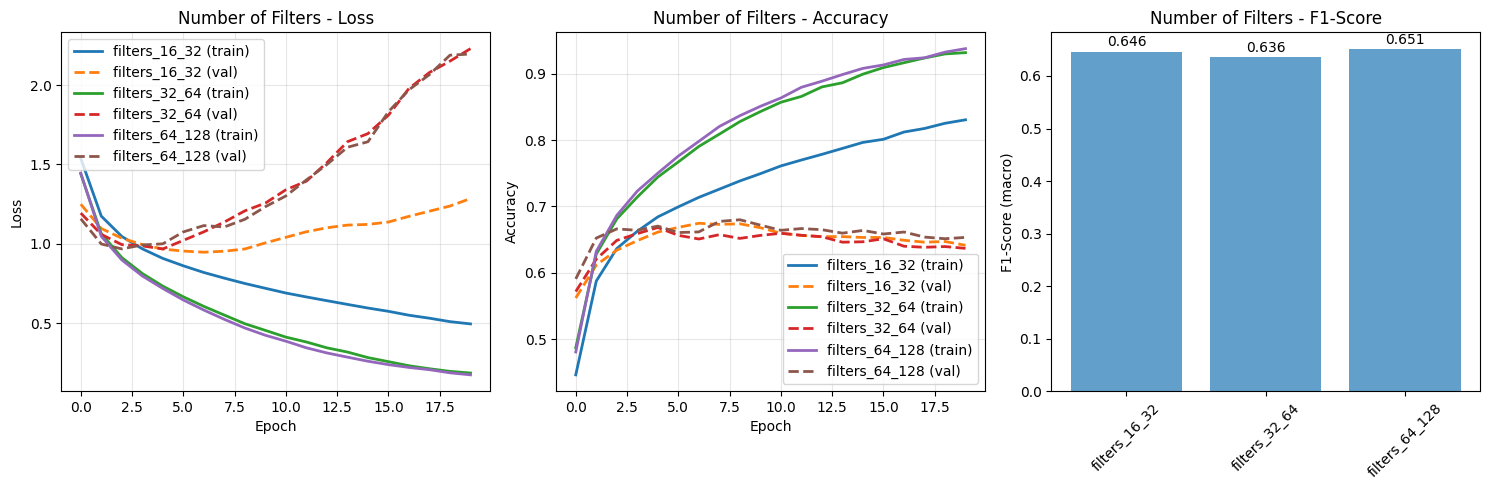


ANALISIS: PENGARUH BANYAK FILTER PER LAYER
Filter 16-32: F1-Score = 0.6456
Filter 32-64: F1-Score = 0.6357
Filter 64-128: F1-Score = 0.6506

KESIMPULAN:
- Performa terbaik: filters_64_128 (F1-Score: 0.6506)
- Performa terburuk: filters_32_64 (F1-Score: 0.6357)

################################################################################
EXPERIMENT 3: PENGARUH UKURAN FILTER (KERNEL)
################################################################################

Training: kernel_3x3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3705 - loss: 1.7143 - val_accuracy: 0.5805 - val_loss: 1.1980
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5910 - loss: 1.1609 - val_accuracy: 0.6194 - val_loss: 1.0785
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6500 - loss: 1.0021 - val_accuracy: 0.6474 - val_loss: 1.0140
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6848 - loss: 0.9052 - val_accuracy: 0.6549 - val_loss: 0.9905
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7116 - loss: 0.8364 - val_accuracy: 0.6669 - val_loss: 0.9740
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7292 - loss: 0.7779 - val_accuracy: 0.6700 - val_loss: 0.9728
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7496 - loss: 0.7255 - val_accuracy: 0.6714 - val_loss: 0.9882
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7649 - loss: 0.6802 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for kernel_3x3:
  Test Accuracy: 0.6238
  Test F1-Score (macro): 0.6240

Training: kernel_5x5
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3767 - loss: 1.6943 - val_accuracy: 0.5761 - val_loss: 1.2139
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5923 - loss: 1.1624 - val_accuracy: 0.6081 - val_loss: 1.1087
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6560 - loss: 0.9918 - val_accuracy: 0.6223 - val_loss: 1.0796
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6957 - loss: 0.8786 - val_accuracy: 0.6438 - val_loss: 1.0371
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7272 - loss: 0.7830 - val_accuracy: 0.6575 - val_loss: 1.0299
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7577 - loss: 0.6944 - val_accuracy: 0.6693 - val_loss: 1.0415
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7803 - loss: 0.6226 - val_accuracy: 0.6593 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for kernel_5x5:
  Test Accuracy: 0.6306
  Test F1-Score (macro): 0.6307

Training: kernel_3x5_mixed
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3674 - loss: 1.7176 - val_accuracy: 0.5866 - val_loss: 1.1953
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5955 - loss: 1.1419 - val_accuracy: 0.6259 - val_loss: 1.0548
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6600 - loss: 0.9697 - val_accuracy: 0.6492 - val_loss: 0.9981
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7015 - loss: 0.8562 - val_accuracy: 0.6657 - val_loss: 0.9716
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7296 - loss: 0.7766 - val_accuracy: 0.6736 - val_loss: 0.9801
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7535 - loss: 0.7098 - val_accuracy: 0.6855 - val_loss: 0.9745
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7747 - loss: 0.6493 - val_accuracy: 0.6992 -

Results for kernel_3x5_mixed:
  Test Accuracy: 0.6547
  Test F1-Score (macro): 0.6591


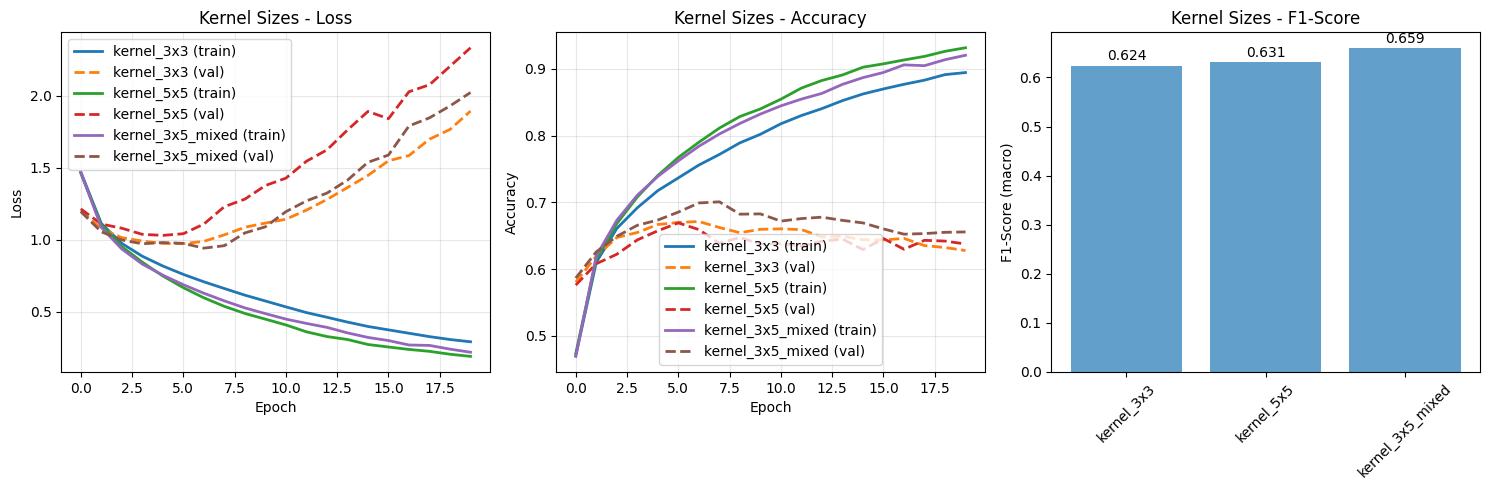


ANALISIS: PENGARUH UKURAN FILTER (KERNEL)
Kernel 3x3: F1-Score = 0.6240
Kernel 5x5: F1-Score = 0.6307
Kernel 3x5 (mixed): F1-Score = 0.6591

KESIMPULAN:
- Performa terbaik: kernel_3x5_mixed (F1-Score: 0.6591)
- Performa terburuk: kernel_3x3 (F1-Score: 0.6240)

################################################################################
EXPERIMENT 4: PENGARUH JENIS POOLING LAYER
################################################################################

Training: max_pooling


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3458 - loss: 1.7679 - val_accuracy: 0.5406 - val_loss: 1.2799
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5812 - loss: 1.1844 - val_accuracy: 0.6113 - val_loss: 1.1030
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6429 - loss: 1.0175 - val_accuracy: 0.6435 - val_loss: 1.0164
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6842 - loss: 0.9121 - val_accuracy: 0.6595 - val_loss: 0.9694
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7122 - loss: 0.8360 - val_accuracy: 0.6684 - val_loss: 0.9499
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7336 - loss: 0.7744 - val_accuracy: 0.6784 - val_loss: 0.9293
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7542 - loss: 0.7170 - val_accuracy: 0.6773 - val_loss: 0.9442
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7734 - loss: 0.6660

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results for max_pooling:
  Test Accuracy: 0.6315
  Test F1-Score (macro): 0.6278

Training: avg_pooling
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3591 - loss: 1.7591 - val_accuracy: 0.5555 - val_loss: 1.2511
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5680 - loss: 1.2186 - val_accuracy: 0.6133 - val_loss: 1.1049
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6329 - loss: 1.0540 - val_accuracy: 0.6336 - val_loss: 1.0497
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6671 - loss: 0.9597 - val_accuracy: 0.6542 - val_loss: 1.0093
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6915 - loss: 0.8895 - val_accuracy: 0.6565 - val_loss: 1.0027
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7106 - loss: 0.8293 - val_accuracy: 0.6592 - val_loss: 1.0026
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7293 - loss: 0.7771 - val_accuracy: 0.6582 - val

Results for avg_pooling:
  Test Accuracy: 0.6615
  Test F1-Score (macro): 0.6581


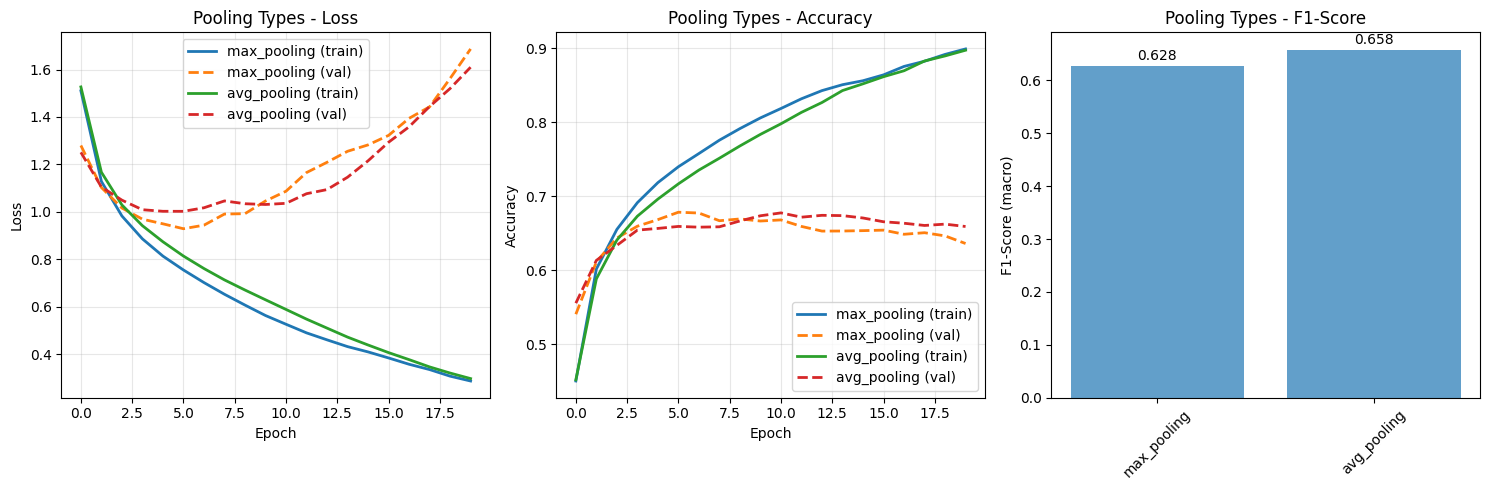


ANALISIS: PENGARUH JENIS POOLING LAYER
Max pooling: F1-Score = 0.6278
Avg pooling: F1-Score = 0.6581

KESIMPULAN:
- Performa terbaik: avg_pooling (F1-Score: 0.6581)
- Performa terburuk: max_pooling (F1-Score: 0.6278)

################################################################################
RINGKASAN KESELURUHAN EKSPERIMEN
################################################################################
Model terbaik secara keseluruhan: 3_conv_layers
F1-Score: 0.6729
Test Accuracy: 0.6784

Ringkasan per eksperimen:
- conv_layers: 3_conv_layers (F1: 0.6729)
- filters: filters_64_128 (F1: 0.6506)
- kernel_sizes: kernel_3x5_mixed (F1: 0.6591)
- pooling: avg_pooling (F1: 0.6581)

Model yang disimpan:
- 1_conv_layer.h5
- 2_conv_layers.h5
- 3_conv_layers.h5
- filters_16_32.h5
- filters_32_64.h5
- filters_64_128.h5
- kernel_3x3.h5
- kernel_5x5.h5
- kernel_3x5_mixed.h5
- max_pooling.h5
- avg_pooling.h5


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
import os
import pickle

class CNNKeras:
    def __init__(self):
        # load cifar10 data
        self.data_loader = DataLoader('cifar10')
        self.x_train, self.x_val, self.x_test, self.y_train, self.y_val, self.y_test = self.data_loader.load_data()

        # normalize data
        self.x_train = self.x_train.astype('float32') / 255.0
        self.x_val = self.x_val.astype('float32') / 255.0
        self.x_test = self.x_test.astype('float32') / 255.0

        print(f"Dataset loaded:")
        print(f"  Training: {self.x_train.shape} - {len(self.y_train)} samples")
        print(f"  Validation: {self.x_val.shape} - {len(self.y_val)} samples")
        print(f"  Test: {self.x_test.shape} - {len(self.y_test)} samples")

    def base_model(self, num_conv_layers=2, filters=[32, 64], kernel_sizes=[3, 3], pooling_type='max'):
        model = keras.Sequential()

        # conv layer pertama
        model.add(layers.Conv2D(filters[0], kernel_sizes[0], activation='relu',
                               input_shape=(32, 32, 3), padding='same', name='conv2d_1'))

        if pooling_type == 'max':
            model.add(layers.MaxPooling2D((2, 2), name='max_pooling2d_1'))
        else:
            model.add(layers.AveragePooling2D((2, 2), name='average_pooling2d_1'))

        # handle kalau ada lebih dari satu layer konvolusi
        for i in range(1, num_conv_layers):
            filter_idx = min(i, len(filters) - 1)
            kernel_idx = min(i, len(kernel_sizes) - 1)

            model.add(layers.Conv2D(filters[filter_idx], kernel_sizes[kernel_idx],
                                   activation='relu', padding='same', name=f'conv2d_{i+1}'))

            if pooling_type == 'max':
                model.add(layers.MaxPooling2D((2, 2), name=f'max_pooling2d_{i+1}'))
            else:
                model.add(layers.AveragePooling2D((2, 2), name=f'average_pooling2d_{i+1}'))

        # Classifier
        model.add(layers.Flatten(name='flatten'))
        model.add(layers.Dense(64, activation='relu', name='dense_1'))
        model.add(layers.Dense(10, activation='softmax', name='dense_2'))

        return model

    def train_and_evaluate(self, model, model_name, epochs=20):
        print(f"\n{'='*60}")
        print(f"Training: {model_name}")
        print(f"{'='*60}")

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            self.x_train, self.y_train,
            batch_size=32,
            epochs=epochs,
            validation_data=(self.x_val, self.y_val),
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(self.x_test, self.y_test, verbose=0)

        y_pred_proba = model.predict(self.x_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        f1_macro = f1_score(self.y_test, y_pred, average='macro')

        # simpan model beserta si bobot
        model.save(f'{model_name}.h5')

        print(f"Results for {model_name}:")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print(f"  Test F1-Score (macro): {f1_macro:.4f}")

        return {
            'model': model,
            'history': history,
            'test_accuracy': test_accuracy,
            'f1_score': f1_macro,
            'predictions': y_pred,
            'model_name': model_name
        }

    # eksperimen layer konvolusi
    def experiment_conv_layers(self, epochs=20):
        print(f"\n{'#'*80}")
        print("EXPERIMENT 1: PENGARUH JUMLAH LAYER KONVOLUSI")
        print(f"{'#'*80}")

        configs = [
            (1, [32], [3], "1_conv_layer"),
            (2, [32, 64], [3, 3], "2_conv_layers"),
            (3, [32, 64, 128], [3, 3, 3], "3_conv_layers")
        ]

        results = {}
        for num_layers, filters, kernels, name in configs:
            model = self.base_model(num_layers, filters, kernels, 'max')
            results[name] = self.train_and_evaluate(model, name, epochs)

        self.plot_comparison(results, "Number of Convolutional Layers")
        self.analyze_conv_layers(results)
        return results

    def experiment_filters(self, epochs=20):
        print(f"\n{'#'*80}")
        print("EXPERIMENT 2: PENGARUH BANYAK FILTER PER LAYER")
        print(f"{'#'*80}")

        configs = [
            ([16, 32], "filters_16_32"),
            ([32, 64], "filters_32_64"),
            ([64, 128], "filters_64_128")
        ]

        results = {}
        for filters, name in configs:
            model = self.base_model(2, filters, [3, 3], 'max')
            results[name] = self.train_and_evaluate(model, name, epochs)

        self.plot_comparison(results, "Number of Filters")
        self.analyze_filters(results)
        return results

    def experiment_kernel_sizes(self, epochs=20):
        print(f"\n{'#'*80}")
        print("EXPERIMENT 3: PENGARUH UKURAN FILTER (KERNEL)")
        print(f"{'#'*80}")

        configs = [
            ([3, 3], "kernel_3x3"),
            ([5, 5], "kernel_5x5"),
            ([3, 5], "kernel_3x5_mixed")
        ]

        results = {}
        for kernels, name in configs:
            model = self.base_model(2, [32, 64], kernels, 'max')
            results[name] = self.train_and_evaluate(model, name, epochs)

        self.plot_comparison(results, "Kernel Sizes")
        self.analyze_kernels(results)
        return results

    def experiment_pooling(self, epochs=20):
        print(f"\n{'#'*80}")
        print("EXPERIMENT 4: PENGARUH JENIS POOLING LAYER")
        print(f"{'#'*80}")

        configs = [
            ('max', "max_pooling"),
            ('avg', "avg_pooling")
        ]

        results = {}
        for pooling, name in configs:
            model = self.base_model(2, [32, 64], [3, 3], pooling)
            results[name] = self.train_and_evaluate(model, name, epochs)

        self.plot_comparison(results, "Pooling Types")
        self.analyze_pooling(results)
        return results

    def plot_comparison(self, results, experiment_name):
        plt.figure(figsize=(15, 5))

        # Training & Validation Loss
        plt.subplot(1, 3, 1)
        for name, result in results.items():
            history = result['history']
            plt.plot(history.history['loss'], label=f'{name} (train)', linewidth=2)
            plt.plot(history.history['val_loss'], label=f'{name} (val)', linestyle='--', linewidth=2)
        plt.title(f'{experiment_name} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Training & Validation Accuracy
        plt.subplot(1, 3, 2)
        for name, result in results.items():
            history = result['history']
            plt.plot(history.history['accuracy'], label=f'{name} (train)', linewidth=2)
            plt.plot(history.history['val_accuracy'], label=f'{name} (val)', linestyle='--', linewidth=2)
        plt.title(f'{experiment_name} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # F1-Score Comparison
        plt.subplot(1, 3, 3)
        names = list(results.keys())
        f1_scores = [results[name]['f1_score'] for name in names]
        bars = plt.bar(names, f1_scores, alpha=0.7)
        plt.title(f'{experiment_name} - F1-Score')
        plt.ylabel('F1-Score (macro)')
        plt.xticks(rotation=45)

        # Add value labels on bars
        for bar, f1 in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{f1:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig(f'{experiment_name.lower().replace(" ", "_")}_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_conv_layers(self, results):
        print(f"\n{'='*60}")
        print("ANALISIS: PENGARUH JUMLAH LAYER KONVOLUSI")
        print(f"{'='*60}")

        for name, result in results.items():
            layers = name.split('_')[0]
            print(f"{layers} layer(s): F1-Score = {result['f1_score']:.4f}")

        best = max(results.items(), key=lambda x: x[1]['f1_score'])
        worst = min(results.items(), key=lambda x: x[1]['f1_score'])

        print(f"\nKESIMPULAN:")
        print(f"- Performa terbaik: {best[0]} (F1-Score: {best[1]['f1_score']:.4f})")
        print(f"- Performa terburuk: {worst[0]} (F1-Score: {worst[1]['f1_score']:.4f})")

    def analyze_filters(self, results):
        print(f"\n{'='*60}")
        print("ANALISIS: PENGARUH BANYAK FILTER PER LAYER")
        print(f"{'='*60}")

        for name, result in results.items():
            filters = name.replace('filters_', '').replace('_', '-')
            print(f"Filter {filters}: F1-Score = {result['f1_score']:.4f}")

        best = max(results.items(), key=lambda x: x[1]['f1_score'])
        worst = min(results.items(), key=lambda x: x[1]['f1_score'])

        print(f"\nKESIMPULAN:")
        print(f"- Performa terbaik: {best[0]} (F1-Score: {best[1]['f1_score']:.4f})")
        print(f"- Performa terburuk: {worst[0]} (F1-Score: {worst[1]['f1_score']:.4f})")

    def analyze_kernels(self, results):
        print(f"\n{'='*60}")
        print("ANALISIS: PENGARUH UKURAN FILTER (KERNEL)")
        print(f"{'='*60}")

        for name, result in results.items():
            kernel = name.replace('kernel_', '').replace('_mixed', ' (mixed)')
            print(f"Kernel {kernel}: F1-Score = {result['f1_score']:.4f}")

        best = max(results.items(), key=lambda x: x[1]['f1_score'])
        worst = min(results.items(), key=lambda x: x[1]['f1_score'])

        print(f"\nKESIMPULAN:")
        print(f"- Performa terbaik: {best[0]} (F1-Score: {best[1]['f1_score']:.4f})")
        print(f"- Performa terburuk: {worst[0]} (F1-Score: {worst[1]['f1_score']:.4f})")

    def analyze_pooling(self, results):
        print(f"\n{'='*60}")
        print("ANALISIS: PENGARUH JENIS POOLING LAYER")
        print(f"{'='*60}")

        for name, result in results.items():
            pooling = name.replace('_pooling', ' pooling')
            print(f"{pooling.capitalize()}: F1-Score = {result['f1_score']:.4f}")

        best = max(results.items(), key=lambda x: x[1]['f1_score'])
        worst = min(results.items(), key=lambda x: x[1]['f1_score'])

        print(f"\nKESIMPULAN:")
        print(f"- Performa terbaik: {best[0]} (F1-Score: {best[1]['f1_score']:.4f})")
        print(f"- Performa terburuk: {worst[0]} (F1-Score: {worst[1]['f1_score']:.4f})")

    def run_all_experiments(self, epochs=20):
        # Run experiments
        conv_results = self.experiment_conv_layers(epochs)
        filter_results = self.experiment_filters(epochs)
        kernel_results = self.experiment_kernel_sizes(epochs)
        pooling_results = self.experiment_pooling(epochs)

        # Save all results
        all_results = {
            'conv_layers': conv_results,
            'filters': filter_results,
            'kernel_sizes': kernel_results,
            'pooling': pooling_results
        }

        with open('experiment_results.pkl', 'wb') as f:
            pickle.dump(all_results, f)

        # Overall summary
        self.print_overall_summary(all_results)

        return all_results

    def print_overall_summary(self, all_results):
        print(f"\n{'#'*80}")
        print("RINGKASAN KESELURUHAN EKSPERIMEN")
        print(f"{'#'*80}")

        all_models = {}
        for exp_name, exp_results in all_results.items():
            all_models.update(exp_results)

        # Find best overall model
        best_overall = max(all_models.items(), key=lambda x: x[1]['f1_score'])

        print(f"Model terbaik secara keseluruhan: {best_overall[0]}")
        print(f"F1-Score: {best_overall[1]['f1_score']:.4f}")
        print(f"Test Accuracy: {best_overall[1]['test_accuracy']:.4f}")

        print(f"\nRingkasan per eksperimen:")
        for exp_name, exp_results in all_results.items():
            best_in_exp = max(exp_results.items(), key=lambda x: x[1]['f1_score'])
            print(f"- {exp_name}: {best_in_exp[0]} (F1: {best_in_exp[1]['f1_score']:.4f})")

        print(f"\nModel yang disimpan:")
        for model_name in all_models.keys():
            print(f"- {model_name}.h5")

def main():
    print("="*80)
    print("CNN HYPERPARAMETER EXPERIMENTS - CIFAR-10")
    print("="*80)

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Initialize experiments
    experiments = CNNKeras()

    # Run all experiments
    results = experiments.run_all_experiments(epochs=20)

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import sys, os

class Conv2D:
    def __init__(self, filters, kernel_size, strides, padding, activation='relu'):
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = activation
        self.kernel = None
        self.bias = None

    def set_weights(self, weights, bias):
        self.weights = weights
        self.bias = bias

    def _pad_input(self, X):
        if self.padding == 'same':
            pad_h = (self.kernel_size - 1) // 2
            pad_w = (self.kernel_size - 1) // 2
            return np.pad(X, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        return X

    def _activation(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        return x

    def forward(self, X):
        X_padded = self._pad_input(X)
        batch_size, H, W, C_in = X_padded.shape
        K_h, K_w, C_in_w, C_out = self.weights.shape

        out_H = (H - K_h) // self.strides + 1
        out_W = (W - K_w) // self.strides + 1

        output = np.zeros((batch_size, out_H, out_W, C_out))

        for i in range(out_H):
            for j in range(out_W):
                h_start = i * self.strides
                h_end = h_start + K_h
                w_start = j * self.strides
                w_end = w_start + K_w

                patch = X_padded[:, h_start:h_end, w_start:w_end, :]

                for f in range(C_out):
                    output[:, i, j, f] = np.sum(patch * self.weights[:, :, :, f], axis=(1, 2, 3)) + self.bias[f]

        return self._activation(output)


class Pooling:
    def __init__(self, pool_type='max', pool_size=2, strides=2, padding='valid'):
        self.pool_type = pool_type
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def _pad_input(self, X):
        if self.padding == 'same':
            pad_h = (self.pool_size - 1) // 2
            pad_w = (self.pool_size - 1) // 2
            return np.pad(X, ((0, 0), (pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant')
        return X

    def forward(self, X):
        X_padded = self._pad_input(X)
        batch_size, H, W, C = X_padded.shape

        out_H = (H - self.pool_size) // self.strides + 1
        out_W = (W - self.pool_size) // self.strides + 1

        output = np.zeros((batch_size, out_H, out_W, C))

        for i in range(out_H):
            for j in range(out_W):
                h_start = i * self.strides
                h_end = h_start + self.pool_size
                w_start = j * self.strides
                w_end = w_start + self.pool_size

                patch = X_padded[:, h_start:h_end, w_start:w_end, :]

                if self.pool_type == 'max':
                    output[:, i, j, :] = np.max(patch, axis=(1, 2))
                else:
                    output[:, i, j, :] = np.mean(patch, axis=(1, 2))

        return output

class Flatten:
    def __init__(self):
        pass

    def forward(self, X):
        batch_size = X.shape[0]
        return X.reshape(batch_size, -1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score
import numpy as np

class CNNModel:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def load_keras_model(self, keras_model):
        self.layers = []

        for i, keras_layer in enumerate(keras_model.layers):
            layer_name = keras_layer.name
            layer_type = type(keras_layer).__name__
            print(f"  Layer {i+1}: {layer_type} ({layer_name})")

            if isinstance(keras_layer, tf.keras.layers.Conv2D):
                config = keras_layer.get_config()
                conv_layer = Conv2D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding'],
                    activation=config['activation']
                )

                weights, bias = keras_layer.get_weights()
                conv_layer.set_weights(weights, bias)
                self.add_layer(conv_layer)
                print(f"    → Conv2D: {config['filters']} filters, {config['kernel_size']}x{config['kernel_size']} kernel")

            elif isinstance(keras_layer, tf.keras.layers.MaxPooling2D):
                config = keras_layer.get_config()
                pool_layer = Pooling(
                    pool_type='max',
                    pool_size=config['pool_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding']
                )
                self.add_layer(pool_layer)
                print(f"    → MaxPooling2D: {config['pool_size']}x{config['pool_size']} pool")

            elif isinstance(keras_layer, tf.keras.layers.AveragePooling2D):
                config = keras_layer.get_config()
                pool_layer = Pooling(
                    pool_type='avg',
                    pool_size=config['pool_size'][0],
                    strides=config['strides'][0],
                    padding=config['padding']
                )
                self.add_layer(pool_layer)
                print(f"    → AveragePooling2D: {config['pool_size']}x{config['pool_size']} pool")

            elif isinstance(keras_layer, tf.keras.layers.Flatten):
                flatten_layer = Flatten()
                self.add_layer(flatten_layer)
                print(f"    → Flatten")

            elif isinstance(keras_layer, tf.keras.layers.Dense):
                config = keras_layer.get_config()
                weights, bias = keras_layer.get_weights()

                dense_layer = DenseLayer(
                    weight=weights,
                    bias=bias,
                    activation=config['activation']
                )
                self.add_layer(dense_layer)
                print(f"    → Dense: {config['units']} units, {config['activation']} activation")

        print(f"✓ Model loaded with {len(self.layers)} layers")

    def forward(self, X):
        output = X
        for i, layer in enumerate(self.layers):
            output = layer.forward(output)
        return output

    def predict(self, X, batch_size=32):
        n_samples = X.shape[0]
        predictions = []

        print(f"Predicting {n_samples} samples in batches of {batch_size}...")

        for i in range(0, n_samples, batch_size):
            batch_end = min(i + batch_size, n_samples)
            batch = X[i:batch_end]

            if i % (batch_size * 10) == 0:
                print(f"  Processing batch {i//batch_size + 1}/{(n_samples-1)//batch_size + 1}")

            batch_pred = self.forward(batch)
            predictions.append(batch_pred)

        return np.vstack(predictions)

class CNNValidator:
    def __init__(self):
        self.data_loader = DataLoader('cifar10')
        _, _, self.x_test, _, _, self.y_test = self.data_loader.load_data()
        self.x_test = self.x_test.astype('float32') / 255.0
        print(f"Test data loaded: {self.x_test.shape}")

    def validate_model(self, model_path, test_samples=500):
        """Validate from-scratch implementation against Keras model"""
        print(f"\n{'='*80}")
        print(f"VALIDATING MODEL: {model_path}")
        print(f"{'='*80}")

        # Load Keras model
        try:
            keras_model = keras.models.load_model(model_path)
            print(f"✓ Keras model loaded: {model_path}")
        except Exception as e:
            print(f"✗ Failed to load Keras model: {e}")
            return None

        # Print model summary
        print("\nKeras model summary:")
        keras_model.summary()

        # Create from-scratch model
        scratch_model = CNNModel()
        scratch_model.load_keras_model(keras_model)

        # Use subset for testing
        x_test_subset = self.x_test[:test_samples]
        y_test_subset = self.y_test[:test_samples]

        print(f"\nTesting with {test_samples} samples...")

        # Get Keras predictions
        print("Getting Keras predictions...")
        keras_pred = keras_model.predict(x_test_subset, batch_size=32, verbose=0)
        keras_classes = np.argmax(keras_pred, axis=1)
        keras_f1 = f1_score(y_test_subset, keras_classes, average='macro')

        # Get from-scratch predictions
        print("Getting from-scratch predictions...")
        scratch_pred = scratch_model.predict(x_test_subset, batch_size=16)
        scratch_classes = np.argmax(scratch_pred, axis=1)
        scratch_f1 = f1_score(y_test_subset, scratch_classes, average='macro')

        # Compare results
        mse_diff = np.mean((keras_pred - scratch_pred) ** 2)
        max_diff = np.max(np.abs(keras_pred - scratch_pred))
        identical_predictions = np.array_equal(keras_classes, scratch_classes)

        # Print detailed comparison for first few samples
        print(f"\nSample predictions comparison (first 5 samples):")
        print("Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label")
        print("-" * 75)
        for i in range(min(5, len(keras_pred))):
            k_pred = keras_pred[i]
            s_pred = scratch_pred[i]
            k_class = keras_classes[i]
            s_class = scratch_classes[i]
            true_label = y_test_subset[i]
            print(f"{i+1:6d} | {k_pred[k_class]:10.6f} | {s_pred[s_class]:11.6f} | {k_class:11d} | {s_class:12d} | {true_label:10d}")

        # Print results
        print(f"\n{'='*60}")
        print("VALIDATION RESULTS")
        print(f"{'='*60}")
        print(f"MSE difference: {mse_diff:.12f}")
        print(f"Max absolute difference: {max_diff:.12f}")
        print(f"Keras F1-Score: {keras_f1:.8f}")
        print(f"From-scratch F1-Score: {scratch_f1:.8f}")
        print(f"F1-Score difference: {abs(keras_f1 - scratch_f1):.8f}")
        print(f"Identical predictions: {identical_predictions}")

        # Validation status
        tolerance = 1e-6
        if mse_diff < tolerance and identical_predictions:
            print("✅ VALIDATION PASSED - Implementation is CORRECT!")
            status = "PASS"
        elif mse_diff < 1e-4:  # More lenient tolerance
            print("⚠️  VALIDATION PASSED with small differences - Implementation is mostly correct")
            status = "PASS"
        else:
            print("❌ VALIDATION FAILED - Implementation needs debugging!")
            status = "FAIL"

        return {
            'model_name': model_path,
            'mse_diff': mse_diff,
            'max_diff': max_diff,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'identical': identical_predictions,
            'status': status
        }

    def validate_all_models(self, test_samples=500):
        """Validate all trained models"""
        print(f"\n{'#'*80}")
        print("VALIDATING ALL TRAINED MODELS")
        print(f"{'#'*80}")

        import os
        model_files = [f for f in os.listdir('.') if f.endswith('.h5')]

        if not model_files:
            print("❌ No .h5 model files found!")
            print("Please run the training script first: python complete_cnn_implementation.py")
            return {}

        print(f"Found {len(model_files)} model files:")
        for f in model_files:
            print(f"  - {f}")

        results = {}
        for model_file in model_files:
            try:
                result = self.validate_model(model_file, test_samples)
                if result:
                    results[model_file] = result
            except Exception as e:
                print(f"❌ Error validating {model_file}: {e}")
                import traceback
                traceback.print_exc()

        self.print_validation_summary(results)
        return results

    def print_validation_summary(self, results):
        """Print summary of all validations"""
        print(f"\n{'#'*80}")
        print("VALIDATION SUMMARY")
        print(f"{'#'*80}")

        if not results:
            print("❌ No successful validations.")
            return

        passed = sum(1 for r in results.values() if r['status'] == 'PASS')
        total = len(results)

        print(f"📊 OVERALL RESULTS:")
        print(f"   Total models tested: {total}")
        print(f"   Passed validation: {passed}")
        print(f"   Failed validation: {total - passed}")
        print(f"   Success rate: {passed/total*100:.1f}%")

        print(f"\n📋 DETAILED RESULTS:")
        for model_name, result in results.items():
            status_icon = "✅" if result['status'] == 'PASS' else "❌"
            print(f"{status_icon} {model_name}:")
            print(f"    MSE difference: {result['mse_diff']:.2e}")
            print(f"    Max difference: {result['max_diff']:.2e}")
            print(f"    F1 difference: {abs(result['keras_f1'] - result['scratch_f1']):.8f}")
            print(f"    Identical predictions: {result['identical']}")

        if passed == total:
            print(f"\n🎉 CONGRATULATIONS!")
            print(f"   All models passed validation!")
            print(f"   Your CNN from-scratch implementation is CORRECT! ✅")
        else:
            print(f"\n⚠️  Some models failed validation.")
            print(f"   Please check the implementation for debugging.")

def quick_test():
    """Quick test with a simple model"""
    print("="*60)
    print("QUICK TEST - Creating and testing a simple model")
    print("="*60)

    # Create simple test model
    model = keras.Sequential([
        keras.layers.Conv2D(8, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
        keras.layers.MaxPooling2D(2),
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create dummy data
    x_dummy = np.random.random((10, 32, 32, 3))
    y_dummy = np.random.randint(0, 10, 10)

    # Quick training
    print("Training simple model...")
    model.fit(x_dummy, y_dummy, epochs=1, verbose=0)

    # Test implementation
    print("Testing implementation...")
    validator = CNNValidator()

    # Use small subset for quick test
    x_test_small = validator.x_test[:50]

    # Keras prediction
    keras_pred = model.predict(x_test_small, verbose=0)

    # From-scratch prediction
    scratch_model = CNNModel()
    scratch_model.load_keras_model(model)
    scratch_pred = scratch_model.predict(x_test_small, batch_size=10)

    # Compare
    mse_diff = np.mean((keras_pred - scratch_pred) ** 2)
    max_diff = np.max(np.abs(keras_pred - scratch_pred))

    print(f"MSE difference: {mse_diff:.10f}")
    print(f"Max difference: {max_diff:.10f}")

    if mse_diff < 1e-6:
        print("✅ Quick test PASSED!")
        return True
    else:
        print("❌ Quick test FAILED!")
        return False

def main():
    print("="*80)
    print("CNN FROM SCRATCH - FINAL VALIDATION")
    print("="*80)

    # Quick test first
    print("Running quick test...")
    if not quick_test():
        print("❌ Quick test failed. Please check implementation.")
        return

    print("\n" + "="*80)
    print("Quick test passed! Proceeding with full validation...")
    print("="*80)

    # Full validation
    validator = CNNValidator()
    results = validator.validate_all_models(test_samples=1000)

    print(f"\n{'='*80}")
    print("VALIDATION COMPLETED!")
    print(f"{'='*80}")

if __name__ == "__main__":
    main()

CNN FROM SCRATCH - FINAL VALIDATION
Running quick test...
QUICK TEST - Creating and testing a simple model
Training simple model...
Testing implementation...
Test data loaded: (10000, 32, 32, 3)


  Layer 1: Conv2D (conv2d_2)
    → Conv2D: 8 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Flatten (flatten_2)
    → Flatten
  Layer 4: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 4 layers
Predicting 50 samples in batches of 10...
  Processing batch 1/5
MSE difference: 0.0000000000
Max difference: 0.0000000652
✅ Quick test PASSED!

Quick test passed! Proceeding with full validation...


Test data loaded: (10000, 32, 32, 3)

################################################################################
VALIDATING ALL TRAINED MODELS
################################################################################
Found 11 model files:
  - 1_conv_layer.h5
  - filters_16_32.h5
  - kernel_3x3.h5
  - kernel_3x5_mixed.h5
  - filters_32_64.h5
  - avg_pooling.h5
  - 2_conv_layers.h5
  - max_pooling.h5
  - filters_64_128.h5
  - 3_conv_layers.h5
  - kernel_5x5.h5

VALIDATING MODEL: 1_conv_layer.h5
✓ Keras model loaded: 1_conv_layer.h5

Keras model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,900 (2.01 MB)

 Trainable params: 525,898 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Flatten (flatten)
    → Flatten
  Layer 4: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 5: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 5 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.863806 |    0.863806 |           2 |            2 |          7
     2 |   0.941626 |    0.941626 |           1 |            1 |          0
     3 |   0.924376 |    0.924376 |           6 |            6 |          6
     4 |   0.630398 |    0.630397 |           0 |            0 |          9
     5 |   0.863155 |    0.863155 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000001240746
Keras F1-Score: 0.61914494
From-scratch F1-Score: 0.61914494
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: filters_16_32.h5
✓ Keras model loaded: filters_16_32.h5

Keras model summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,876 (534.68 KB)

 Trainable params: 136,874 (534.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 16 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.429462 |    0.429463 |           3 |            3 |          7
     2 |   0.999594 |    0.999594 |           0 |            0 |          0
     3 |   0.945007 |    0.945007 |           6 |            6 |          6
     4 |   0.804858 |    0.804858 |           8 |            8 |          9
     5 |   0.496974 |    0.496975 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000001749539
Keras F1-Score: 0.61020379
From-scratch F1-Score: 0.61020379
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: kernel_3x3.h5
✓ Keras model loaded: kernel_3x3.h5

Keras model summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,252 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.980172 |    0.980172 |           7 |            7 |          7
     2 |   0.999801 |    0.999801 |           1 |            1 |          0
     3 |   0.993414 |    0.993414 |           6 |            6 |          6
     4 |   0.988394 |    0.988394 |           9 |            9 |          9
     5 |   0.919478 |    0.919478 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002156196
Keras F1-Score: 0.66918825
From-scratch F1-Score: 0.66918825
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: kernel_3x5_mixed.h5
✓ Keras model loaded: kernel_3x5_mixed.h5

Keras model summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,020 (1.20 MB)

 Trainable params: 315,018 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (5, 5)x(5, 5) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.486164 |    0.486163 |           2 |            2 |          7
     2 |   0.939227 |    0.939227 |           1 |            1 |          0
     3 |   0.786478 |    0.786478 |           4 |            4 |          6
     4 |   0.947324 |    0.947323 |           9 |            9 |          9
     5 |   0.996812 |    0.996812 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002202639
Keras F1-Score: 0.67758417
From-scratch F1-Score: 0.67758417
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: filters_32_64.h5
✓ Keras model loaded: filters_32_64.h5

Keras model summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,252 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.943131 |    0.943131 |           7 |            7 |          7
     2 |   0.840061 |    0.840061 |           0 |            0 |          0
     3 |   0.999992 |    0.999992 |           6 |            6 |          6
     4 |   0.691538 |    0.691538 |           6 |            6 |          9
     5 |   0.993021 |    0.993021 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000001736096
Keras F1-Score: 0.65620119
From-scratch F1-Score: 0.65620119
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: avg_pooling.h5
✓ Keras model loaded: avg_pooling.h5

Keras model summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,252 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: AveragePooling2D (average_pooling2d_1)
    → AveragePooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: AveragePooling2D (average_pooling2d_2)
    → AveragePooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.989009 |    0.989009 |           5 |            5 |          7
     2 |   0.982919 |    0.982919 |           1 |            1 |          0
     3 |   0.945301 |    0.945302 |           6 |            6 |          6
     4 |   0.844735 |    0.844735 |           9 |            9 |          9
     5 |   0.982771 |    0.982771 |           7 |            7 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000001364982
Keras F1-Score: 0.66945387
From-scratch F1-Score: 0.66945387
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: 2_conv_layers.h5
✓ Keras model loaded: 2_conv_layers.h5

Keras model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,252 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.916345 |    0.916345 |           7 |            7 |          7
     2 |   0.726689 |    0.726689 |           9 |            9 |          0
     3 |   0.996111 |    0.996111 |           2 |            2 |          6
     4 |   0.982341 |    0.982341 |           9 |            9 |          9
     5 |   0.999824 |    0.999824 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002446661
Keras F1-Score: 0.63924557
From-scratch F1-Score: 0.63924557
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: max_pooling.h5
✓ Keras model loaded: max_pooling.h5

Keras model summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,252 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.999675 |    0.999675 |           2 |            2 |          7
     2 |   0.878194 |    0.878193 |           0 |            0 |          0
     3 |   0.586323 |    0.586323 |           6 |            6 |          6
     4 |   0.432911 |    0.432913 |           4 |            4 |          9
     5 |   0.999779 |    0.999779 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002373204
Keras F1-Score: 0.64888851
From-scratch F1-Score: 0.64888851
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: filters_64_128.h5
✓ Keras model loaded: filters_64_128.h5

Keras model summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,652 (2.29 MB)

 Trainable params: 600,650 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 128 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.882080 |    0.882080 |           7 |            7 |          7
     2 |   0.999082 |    0.999082 |           0 |            0 |          0
     3 |   0.728284 |    0.728285 |           6 |            6 |          6
     4 |   0.999173 |    0.999173 |           8 |            8 |          9
     5 |   0.999216 |    0.999216 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002892862
Keras F1-Score: 0.66214276
From-scratch F1-Score: 0.66214276
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: 3_conv_layers.h5
✓ Keras model loaded: 3_conv_layers.h5

Keras model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,036 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (3, 3)x(3, 3) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (3, 3)x(3, 3) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Conv2D (conv2d_3)
    → Conv2D: 128 filters, (3, 3)x(3, 3) kernel
  Layer 6: MaxPooling2D (max_pooling2d_3)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 7: Flatten (flatten)
    → Flatten
  Layer 8: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 9: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 9 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63



Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
---------------------------------------------------------------------------
     1 |   0.735022 |    0.735021 |           5 |            5 |          7
     2 |   0.998292 |    0.998291 |           0 |            0 |          0
     3 |   0.998708 |    0.998708 |           6 |            6 |          6
     4 |   0.975624 |    0.975624 |           8 |            8 |          9
     5 |   0.880377 |    0.880377 |           5 |            5 |          5

VALIDATION RESULTS
MSE difference: 0.000000000000
Max absolute difference: 0.000002875605
Keras F1-Score: 0.69910976
From-scratch F1-Score: 0.69910976
F1-Score difference: 0.00000000
Identical predictions: True
✅ VALIDATION PASSED - Implementation is CORRECT!

VALIDATING MODEL: kernel_5x5.h5
✓ Keras model loaded: kernel_5x5.h5

Keras model summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,556 (1.21 MB)

 Trainable params: 316,554 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

  Layer 1: Conv2D (conv2d_1)
    → Conv2D: 32 filters, (5, 5)x(5, 5) kernel
  Layer 2: MaxPooling2D (max_pooling2d_1)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 3: Conv2D (conv2d_2)
    → Conv2D: 64 filters, (5, 5)x(5, 5) kernel
  Layer 4: MaxPooling2D (max_pooling2d_2)
    → MaxPooling2D: (2, 2)x(2, 2) pool
  Layer 5: Flatten (flatten)
    → Flatten
  Layer 6: Dense (dense_1)
    → Dense: 64 units, relu activation
  Layer 7: Dense (dense_2)
    → Dense: 10 units, softmax activation
✓ Model loaded with 7 layers

Testing with 1000 samples...
Getting Keras predictions...
Getting from-scratch predictions...
Predicting 1000 samples in batches of 16...
  Processing batch 1/63
  Processing batch 11/63
  Processing batch 21/63
  Processing batch 31/63
  Processing batch 41/63
  Processing batch 51/63
  Processing batch 61/63

Sample predictions comparison (first 5 samples):
Sample | Keras Pred | Scratch Pred | Keras Class | Scratch Class | True Label
--------------------------------------